# Training a convolution neural network to segment retina image

Trains a UNet on the [DRIVE dataset](http://www.isi.uu.nl/Research/Databases/DRIVE/) [Staal et al, 2004] to segment retinal images.

J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "[Ridge based vessel segmentation in color images of the retina](http://www.isi.uu.nl/Research/Databases/DRIVE/id=855.html)", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from skimage.transform import resize # resize images

# Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1

In [2]:
# unzip data set
with zipfile.ZipFile("../data/DRIVE_retinal_image_data.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [3]:
# load training images
fns = sorted(glob.glob('../data/DRIVE/training/images/*.tif'))
#print(fns)
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('../data/DRIVE/test/images/*.tif'))
#print(fns)
x_test = np.array([tifffile.imread(fn) for fn in fns])
print(x_train.shape)
print(x_test.shape)

/Users/wdeback/anaconda/envs/dl-tut/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


(31, 584, 565, 3)
(9, 584, 565, 3)


In [4]:
# load training annotations
fns = sorted(glob.glob('../data/DRIVE/training/labels/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('../data/DRIVE/test/labels/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension

**Preprocessing**

- Convert to float32
- Rescale to 0-1 interval

In [5]:
def preprocess(ims):
    # convert to float32
    ims = ims.astype(np.float32)

    # scale to 0-1 interval
    if ims.max() > 1.0:
        ims /= 255.
    
    print('min: {}, max: {}, shape: {}, type: {}'.format(ims.min(), ims.max(), ims.shape, ims.dtype))
    return ims

x_train = preprocess(x_train)
x_test = preprocess(x_test)

y_train = preprocess(y_train)
y_test = preprocess(y_test)


min: 0.0, max: 1.0, shape: (31, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (31, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (9, 584, 565, 1), type: float32


**Data augmentation**

- Generate a large collection of small image/segmentation snippets

In [6]:
def random_snippet(x, y, size=(48,48), rotate=True, flip=True):
    '''sample snippets from images. return image tuple (real, segmentation) of size `size` '''
    
    assert x.shape[:2] == y.shape[:2]
    
    # get image sample
    sample = np.random.randint(0, x.shape[0])
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[sample, min_h:max_h, min_w:max_w, :]
    im_y = y[sample, min_h:max_h, min_w:max_w, :]
    
    # rotate
    if rotate:
        k = np.random.randint(0,4)
        im_x = np.rot90(im_x, k=k, axes=(0,1))
        im_y = np.rot90(im_y, k=k, axes=(0,1))
        
    # flip left-right, up-down
    if flip:
        if np.random.random() < 0.5:
            lr_ud = np.random.randint(0,2) # flip up-down or left-right?
            im_x = np.flip(im_x, axis=lr_ud)
            im_y = np.flip(im_y, axis=lr_ud)
            
    
    
    return (im_x, im_y)

def get_random_snippets(x, y, number, size):
    snippets = [random_snippet(x, y, size) for i in range(number) ]
     
    ims_x = np.array([i[0] for i in snippets])
    ims_y = np.array([i[1] for i in snippets])
    return (ims_x, ims_y)

In [7]:
X_train, Y_train = get_random_snippets(x_train, y_train, number=1000, size=(48,48))
X_test, Y_test = get_random_snippets(x_train, y_train, number=100, size=(48,48))

print(X_train.shape)
print(Y_train.shape)


(1000, 48, 48, 3)
(1000, 48, 48, 1)


**Plot random snippets**

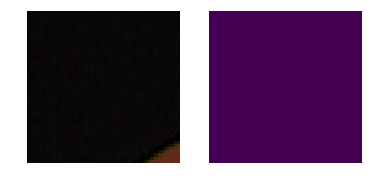

In [8]:
n = 16 
indices = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(4,4,figsize=(12,12))
ax = ax.flatten()
for a in ax:
    a.imshow(X_train[indices])
    a.imshow(np.squeeze(Y_train[indices]))
    a.axis('off')


# Define a convolutional neural network

In [25]:
def UNet():
    '''U net architecture (down/up sampling with skip architecture)
    '''
    from keras.layers import Input, Dropout, Activation, BatchNormalization, Conv2D, Concatenate, UpSampling2D
    from keras.models import Model
    def Conv2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        return Dropout(rate=0.2)(
                Activation(activation='relu')(
                    BatchNormalization(scale=False)(
                        Conv2D(n_filters, kernel_size, strides=strides, padding='same', kernel_initializer='glorot_normal')(inputs))))

    i = Input((None, None, 3))
    
    layer1 = Conv2DReluBatchNorm(32,  (5, 5), (1,1), i)    
    layer2 = Conv2DReluBatchNorm(64,  (5, 5), (2,2), layer1)
    layer3 = Conv2DReluBatchNorm(128, (3, 3), (2,2), layer2)
    layer4 = Conv2DReluBatchNorm(256, (3, 3), (2,2), layer3)
    layer5 = Conv2DReluBatchNorm(512, (3, 3), (2,2), layer4)

    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer5), layer4])
    layer6 = Conv2DReluBatchNorm(256, (3, 3), (1,1), merge6)
    
    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer6), layer3])
    layer7 = Conv2DReluBatchNorm(128, (3, 3), (1,1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer7), layer2])
    layer8 = Conv2DReluBatchNorm(64, (3, 3), (1,1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer8), layer1])
    layer9 = Conv2DReluBatchNorm(32, (3, 3), (1,1), merge9)

    o = Conv2D(1, (1, 1), strides=(1,1), activation='sigmoid')(layer9)

    return Model(inputs=i, outputs=o)

__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

As a loss function, we'll use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).

In [26]:
from keras import backend as K
def dice_coefficient(y_true, y_pred):
    """
    A statistic used for comparing the similarity of two samples. Here binary segmentations.

    Args:
        y_true (numpy.array): the true segmentation
        y_pred (numpy.array): the predicted segmentation

    Returns:
        (float) returns a number from 0. to 1. measuring the similarity y_true and y_pred
    """
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)

In [27]:
from keras import optimizers

model = UNet()
model.compile(optimizer=optimizers.Adam(lr=0.001), loss=dice_loss, metrics=[dice_coefficient])
print("Number of parameters: ", model.count_params())
model.summary()

Number of parameters:  3957889
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 2432        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 3 0           batch_normalization_19[0][0]     
______________________________________________________________________________

# Train the neural network

In [28]:
batch_size = 32
epochs = 10

In [29]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_data=(X_test, Y_test))


Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 108s 108ms/step - loss: -0.2528 - dice_coefficient: 0.2528 - val_loss: -0.2090 - val_dice_coefficient: 0.2090

KeyboardInterrupt: 

In [30]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
plot_history(history, validation=True)

NameError: name 'history' is not defined

We need to pad the input images to 'fit' into the UNet. That is, the image size should be a multiple of 16 in case of depth=4 or 32 if depth=5.

# Predict unseen examples

In [ ]:
x_test.shape
newsize = [640, 640]
pw = np.subtract(newsize, x_test.shape[1:3])
x_test_padded = np.pad(x_test, pad_width=((0,0), (0,pw[0]), (0,pw[1]), (0,0)), mode='constant')
y_test_padded = np.pad(y_test, pad_width=((0,0), (0,pw[0]), (0,pw[1]), (0,0)), mode='constant')

In [ ]:
score = model.evaluate(x_test_padded, y_test_padded, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
num=1
indices = np.random.choice(len(x_test_padded), size=num)
import time
start = time.time()
y_pred = model.predict(x_test_padded[indices], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

gt = np.argmax(y_test_padded[:num], axis=1) 
gt

In [ ]:
plot_images(x_test_padded[indices], y_test_padded, gt=gt)